[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/peteyeh/celltrack/HEAD?labpath=feature_extraction.ipynb)

In [1]:
%matplotlib inline

import cv2
import imageio
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from collections import Counter
from joblib import cpu_count, delayed, Parallel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

from src.displaytools import *
from src.ftextraction import *
from src.improcessing import *
from src.maskcreation import *

# Read in image file

In [2]:
image_stack = cv2.imreadmulti('source_images/Adherent.tif', flags=cv2.IMREAD_GRAYSCALE)[1]

# Train models

## Extract mask image

In [3]:
image_gray = scale_image(image_stack[-1])

params = 'src/params/median_filter.yml'
params2 = 'src/params/hpf_rb_manual.yml'

mask_image, search_range = get_mask_image_with_refined_offset(image_gray, params, verbosity=0)
mask_image2, search_range2 = get_mask_image_with_refined_offset(image_gray, params2, verbosity=0)

## Extract features, then standardize and reduce dimensions

In [4]:
df, mask_labels = extract_features(image_gray, mask_image)

# display(df)

df2, mask_labels2 = extract_features(image_gray, mask_image2)
# display(df2)

2024-05-15 11:14:45,160 - No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
2024-05-15 11:14:45,161 - Enabled image types: {'Original': {}}
2024-05-15 11:14:45,162 - Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
2024-05-15 11:14:45,164 - Calculating features with label: 1
2024-05-15 11:14:45,164 - Loading image and mask
2024-05-15 11:14:45,233 - Computing shape2D
2024-05-15 11:14:45,234 - Adding image type "Original" with custom settings: {}
2024-05-15 11:14:45,235 - Calculating features for original image
2024-05-15 11:14:45,237 - Computing firstorder
2024-05-15 11:14:45,240 - Computing glcm
2024-0

In [5]:
scaler = StandardScaler()
pca = PCA() if len(df) <= len(df.columns) else PCA(n_components='mle')

scaled = scaler.fit_transform(pca.fit_transform(df))
dft = pd.DataFrame(scaled, index=df.index)
# display(dft)

scaler2 = StandardScaler()
pca2 = PCA() if len(df2) <= len(df2.columns) else PCA(n_components='mle')

scaled2 = scaler2.fit_transform(pca2.fit_transform(df2))
dft2 = pd.DataFrame(scaled2, index=df2.index)
# display(dft2)

## Determine number of clusters

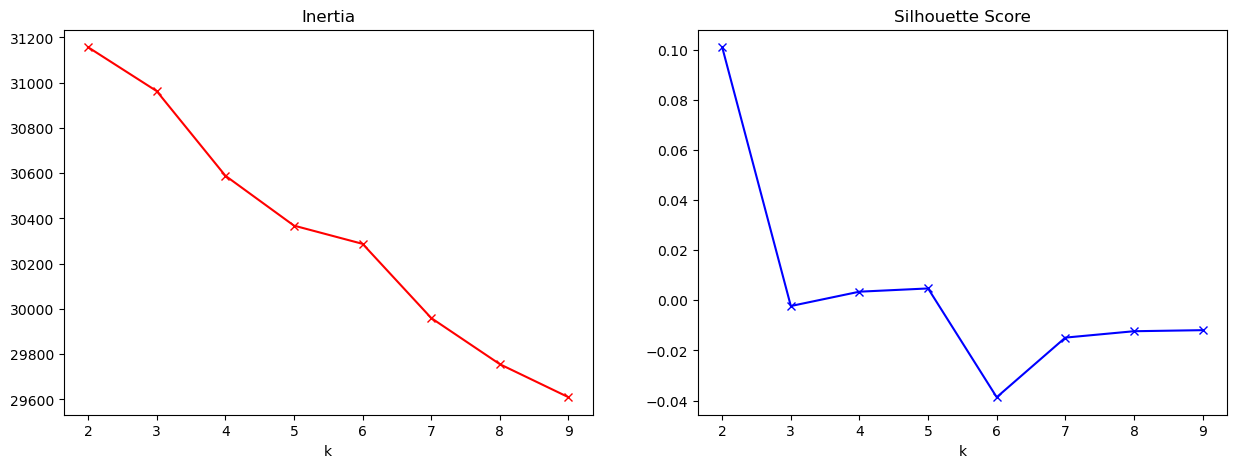

In [6]:
inertias = []
silhouette_scores = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(dft)
    inertias += [kmeans.inertia_,]
    silhouette_scores += [silhouette_score(dft, labels),]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(k_range, inertias, 'rx-')
ax1.set(xlabel='k', title="Inertia")
ax2.plot(k_range, silhouette_scores,'bx-')
ax2.set(xlabel='k', title="Silhouette Score")
plt.show()

# inertias = []
# silhouette_scores = []
# k_range = range(2, 10)
# for k in k_range:
#     kmeans = KMeans(n_clusters=k, random_state=0)
#     labels = kmeans.fit_predict(dft2)
#     inertias += [kmeans.inertia_,]
#     silhouette_scores += [silhouette_score(dft2, labels),]

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# ax1.plot(k_range, inertias, 'rx-')
# ax1.set(xlabel='k', title="Inertia")
# ax2.plot(k_range, silhouette_scores,'bx-')
# ax2.set(xlabel='k', title="Silhouette Score")
# plt.show()

## User-defined values

`colormap` should contain `global_k` colors.

In [7]:
# Manually select k based on visual inspection above
global_k = 6

# Classification colors (include k colors, or use colormap string)
colormap = matplotlib.colors.ListedColormap(['yellow', 'red', 'cyan', 'orange', 'green', 'purple'])

## Fit and classify using k-means

In [8]:
kmeans = KMeans(n_clusters=global_k, random_state=0)
labels = kmeans.fit_predict(dft)
# print_label_counts(labels, colormap)

kmeans2 = KMeans(n_clusters=global_k, random_state=0)
labels2 = kmeans2.fit_predict(dft2)
# print_label_counts(labels2, colormap)

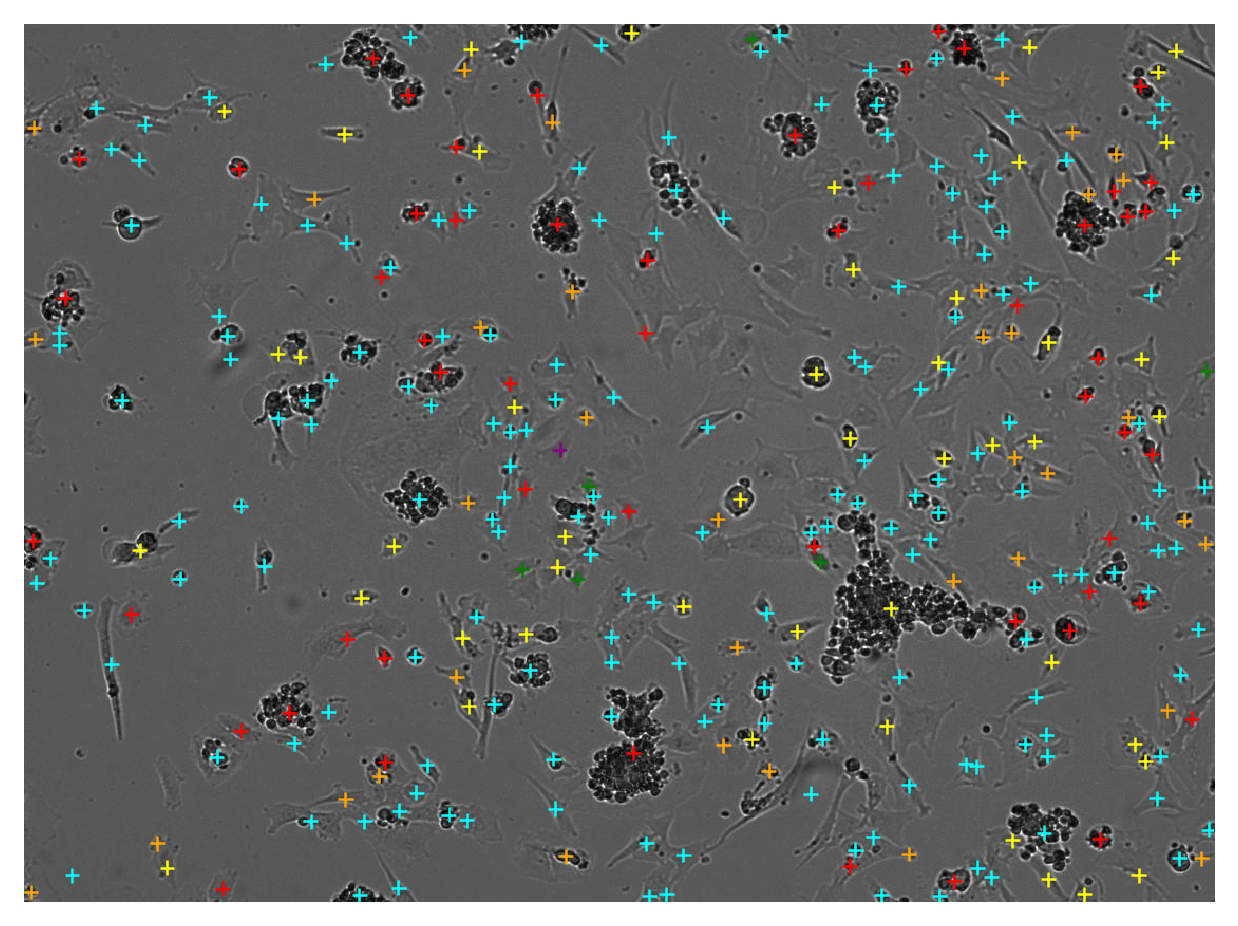

In [9]:
display_classifications(image_gray, dft.index, labels, colormap)

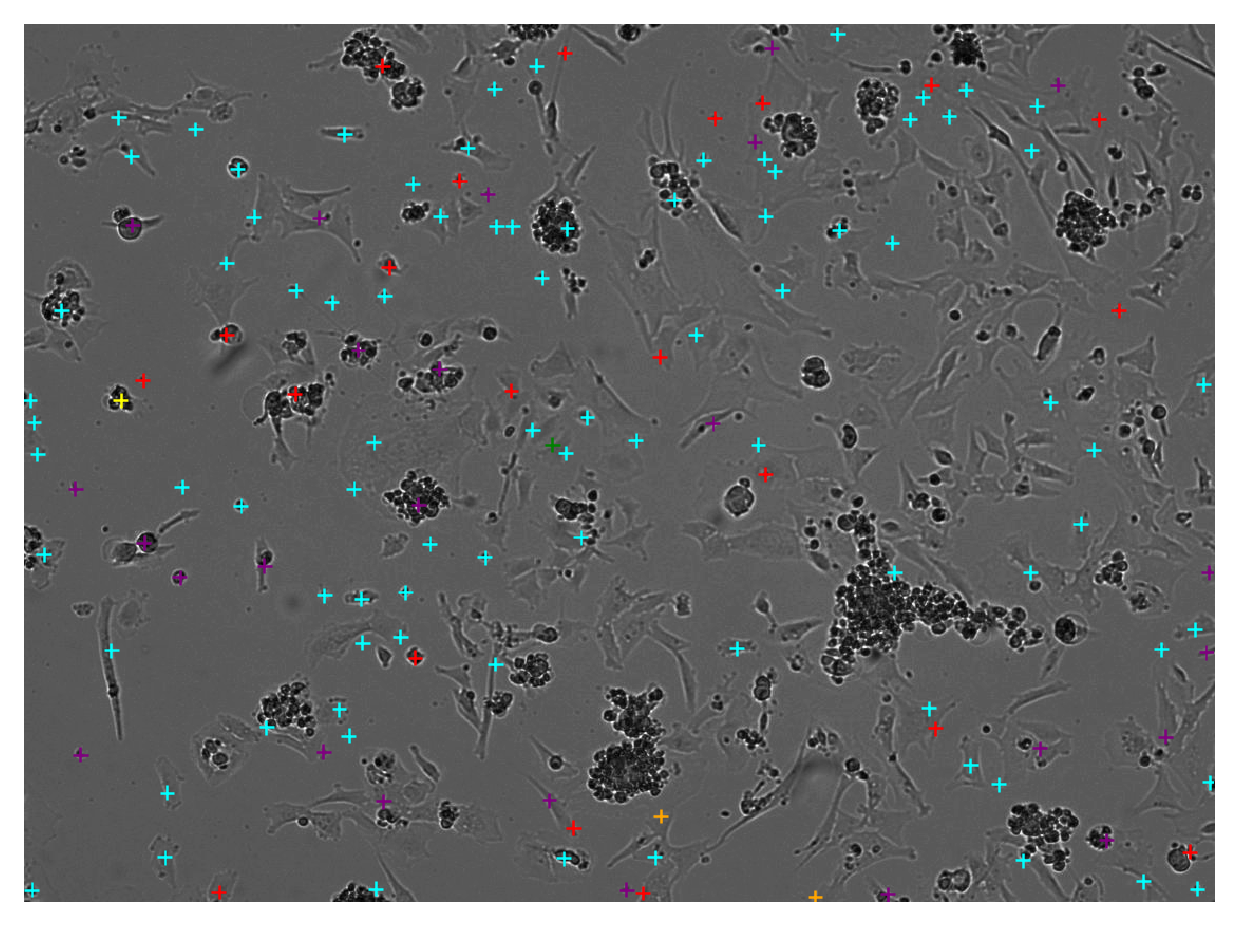

In [10]:
display_classifications(image_gray, dft2.index, labels2, colormap)

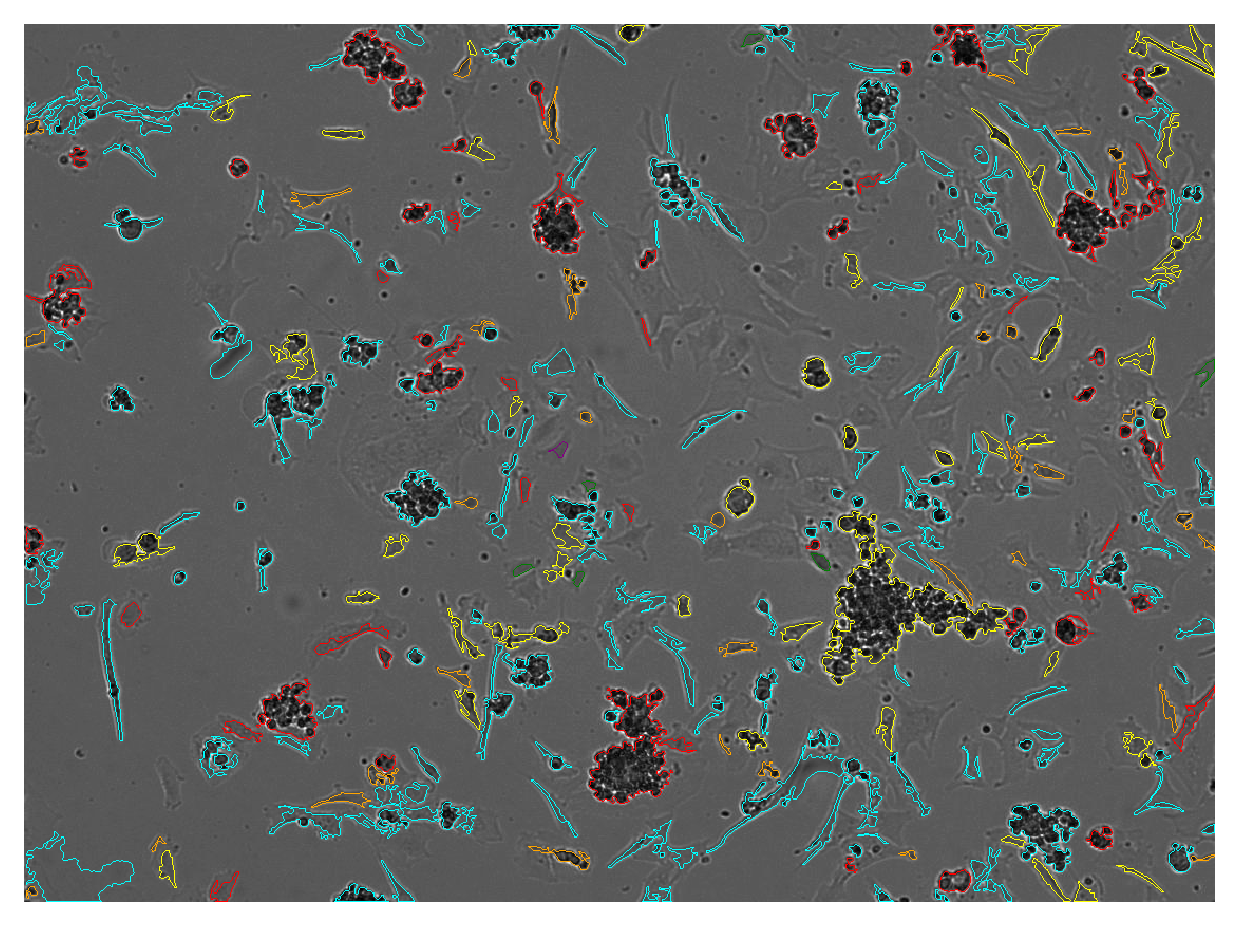

In [11]:
display_image(get_contoured_image(image_gray, mask_labels, labels, colormap))

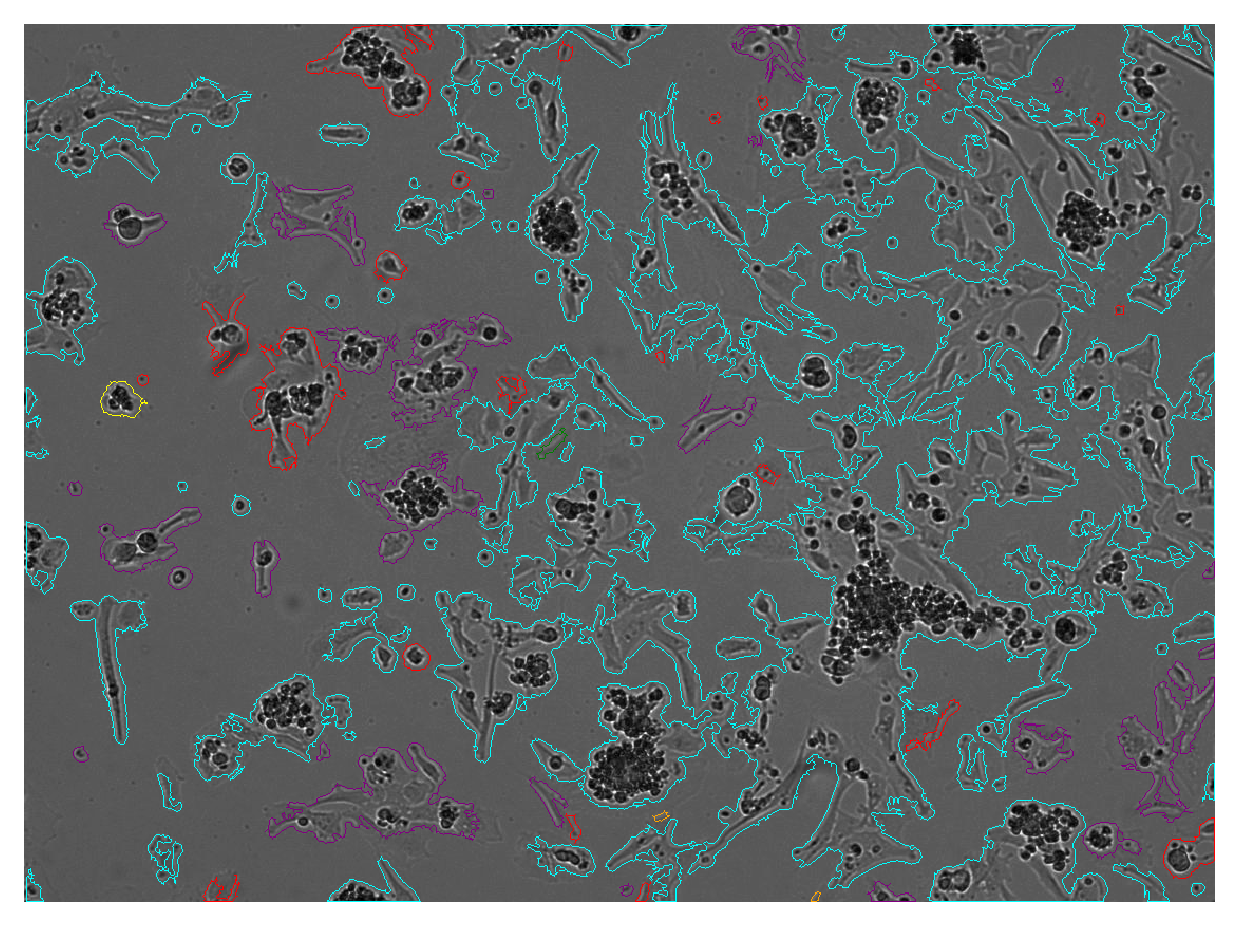

In [12]:
display_image(get_contoured_image(image_gray, mask_labels2, labels2, colormap))

Unfortunately `sklearn` doesn't let us set a colormap here so disregard the inconsistent coloring.

/Users/mattanikiej/miniconda3/envs/practicum/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


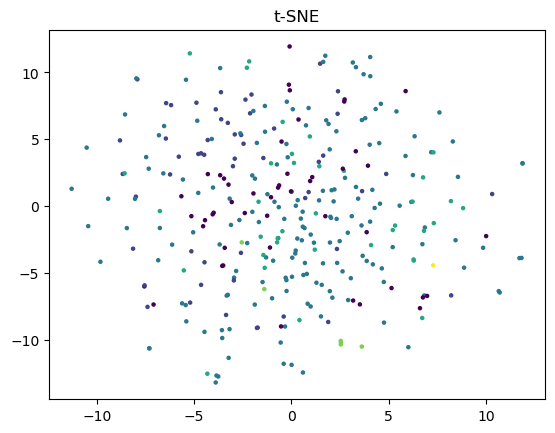

In [13]:
display_tsne(dft, labels)

/Users/mattanikiej/miniconda3/envs/practicum/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


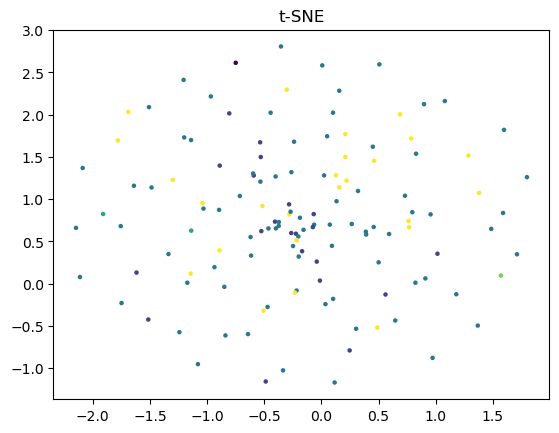

In [14]:
display_tsne(dft2, labels2)

# Estimate feature importance

In [15]:
num_features = 3

for k in range(labels.max()+1):
    y = np.uint8(labels==k)
    lr = LogisticRegression().fit(scaled, y)
    sorted_features = [(y, x) for x, y in sorted(zip(lr.coef_[0], df.columns))]
    print("Class %i:" % k)
    for feature, coeff in sorted_features[-num_features:]:
        print("  %s: %.3f" % (feature.replace("original_", ""), coeff))
    print("  ...")
    for feature, coeff in reversed(sorted_features[:num_features]):
        print("  %s: %.3f" % (feature.replace("original_", ""), coeff))


# for k in range(labels2.max()+1):
#     y = np.uint8(labels2==k)
#     lr = LogisticRegression().fit(scaled2, y)
#     sorted_features = [(y, x) for x, y in sorted(zip(lr.coef_[0], df2.columns))]
#     print("Class %i:" % k)
#     for feature, coeff in sorted_features[-num_features:]:
#         print("  %s: %.3f" % (feature.replace("original_", ""), coeff))
#     print("  ...")
#     for feature, coeff in reversed(sorted_features[:num_features]):
#         print("  %s: %.3f" % (feature.replace("original_", ""), coeff))

Class 0:
  firstorder_Variance: 1.001
  gldm_GrayLevelNonUniformity: 1.079
  glrlm_RunPercentage: 1.229
  ...
  glcm_Idmn: -0.744
  glcm_SumSquares: -0.913
  shape2D_Sphericity: -1.071
Class 1:
  glcm_DifferenceVariance: 0.943
  glrlm_RunVariance: 0.947
  shape2D_Perimeter: 1.035
  ...
  gldm_DependenceVariance: -0.782
  glszm_LargeAreaLowGrayLevelEmphasis: -0.922
  glcm_Idmn: -1.260
Class 2:
  ngtdm_Strength: 1.125
  firstorder_MeanAbsoluteDeviation: 1.218
  glcm_Idmn: 1.692
  ...
  firstorder_InterquartileRange: -1.165
  glrlm_RunEntropy: -1.208
  gldm_LargeDependenceLowGrayLevelEmphasis: -1.270
Class 3:
  glcm_DifferenceAverage: 0.856
  glcm_Idn: 0.953
  glrlm_RunEntropy: 1.534
  ...
  ngtdm_Complexity: -0.884
  ngtdm_Strength: -0.894
  glrlm_LongRunEmphasis: -1.271
Class 4:
  glcm_DifferenceEntropy: 0.387
  glszm_SizeZoneNonUniformity: 0.407
  glszm_LargeAreaEmphasis: 0.455
  ...
  glcm_SumSquares: -0.381
  ngtdm_Complexity: -0.415
  glcm_Idn: -0.550
Class 5:
  firstorder_Range: 0.

# Create Mask Using Difference Of Previous 2

(832, 1128)


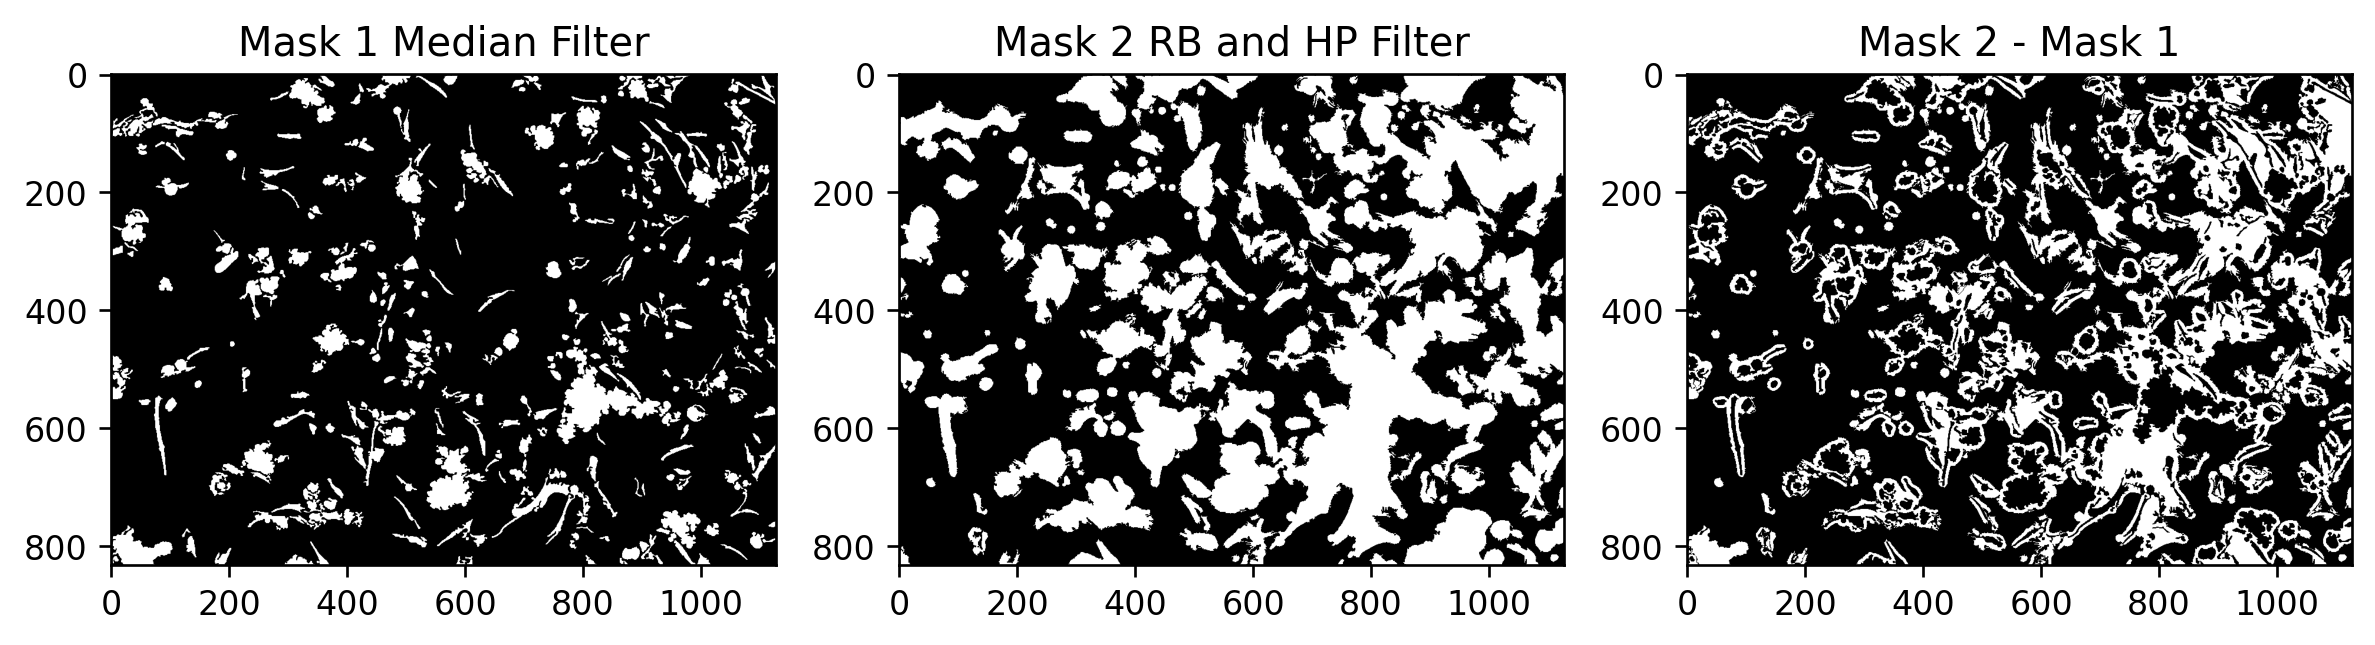

2024-05-15 11:15:28,490 - No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
2024-05-15 11:15:28,491 - Enabled image types: {'Original': {}}
2024-05-15 11:15:28,491 - Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
2024-05-15 11:15:28,492 - Calculating features with label: 1
2024-05-15 11:15:28,493 - Loading image and mask
2024-05-15 11:15:28,559 - Computing shape2D
2024-05-15 11:15:28,561 - Adding image type "Original" with custom settings: {}
2024-05-15 11:15:28,562 - Calculating features for original image
2024-05-15 11:15:28,564 - Computing firstorder
2024-05-15 11:15:28,567 - Computing glcm
2024-0

ValueError: mask has too few dimensions (number of dimensions 1, minimum required 2)

In [16]:
mask_image_dif = np.clip(mask_image2 - mask_image,0,1)
# print(mask_image.shape)
# print(mask_image.dtype)
# print(mask_image.min())
# print(mask_image.max())

# print(mask_image2.shape)
# print(mask_image2.dtype)
# print(mask_image2.min())
# print(mask_image2.max())

print(mask_image_dif.shape)
# print(mask_image_dif.dtype)
# print(mask_image_dif.min())
# print(mask_image_dif.max())

plt.figure(figsize=(10,7), dpi=240)

plt.subplot(131)
plt.imshow(mask_image, cmap='gray')
plt.title('Mask 1 Median Filter')

plt.subplot(132)
plt.imshow(mask_image2, cmap='gray')
plt.title('Mask 2 RB and HP Filter')

plt.subplot(133)
plt.title('Mask 2 - Mask 1')
plt.imshow(mask_image_dif, cmap='gray')

plt.tight_layout()

plt.show()

# df_dif, mask_labels_dif = extract_features(image_gray, mask_image_dif)

In [ ]:
scaler_dif = StandardScaler()
pca_dif = PCA(n_components=len(dft.columns))

scaled_dif = scaler_dif.fit_transform(pca_dif.fit_transform(df_dif))
dft_dif = pd.DataFrame(scaled_dif, index=df_dif.index)
display(dft_dif)

In [ ]:
kmeans_dif = KMeans(n_clusters=global_k, random_state=0)
labels_dif = kmeans_dif.fit_predict(dft_dif)

In [ ]:
display_classifications(image_gray, dft_dif.index, labels_dif, colormap)

In [ ]:
display_image(get_contoured_image(image_gray, mask_labels_dif, labels_dif, colormap))

In [ ]:
display_tsne(dft_dif, labels_dif)